In [1]:
#%% Setting Up
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
# import xesmf as xe
import networkx as nx
# import rioxarray as rxr

import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from shapely.geometry import Point
from shapely.geometry import Polygon

import glob
import os
import itertools
import tqdm
import gc
import time
import pickle

from joblib import Parallel, delayed

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/data/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

print("Setting up...")

Setting up...


In [7]:
Paper_Data_Latency = '/data/sarth/rootdir/workdir/projects/Paper_Data_Latency'

# IND

In [84]:
#%% Region-Specific: CAMELS-IND
DIRNAME = '03min_GloFAS_CAMELS-IND'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': 66,
    'miny': 5,
    'maxx': 100,
    'maxy': 30
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(5))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['ghi_area'] <= 30000]
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
camels_graph = camels_graph.rename(columns = {'ghi_lon': 'gauge_lon', 'ghi_lat': 'gauge_lat'})
print(f"Number of catmt's: {len(camels_graph)}")
del camels_attributes_graph

Number of catmt's: 191


In [85]:
all_watershed_names = sorted(glob.glob(os.path.join(PATHS['CAMELS'], 'CAMELS-IND', 'CAMELS_IND_All_Catchments', 'shapefiles_catchment', '*')))
all_watershed_names = [x for x in all_watershed_names if os.path.isdir(x) and os.path.basename(x) != 'merged']
all_watershed_shps = [os.path.join(x, os.path.basename(x) + '.shp') for x in all_watershed_names]
all_watershed_shps = [gpd.read_file(x) for x in all_watershed_shps]
all_watersheds = gpd.GeoDataFrame(pd.concat(all_watershed_shps, ignore_index=True))
all_watersheds = all_watersheds.to_crs(epsg=4326)
all_watersheds['watershed'] = [os.path.basename(x) for x in all_watershed_names]
all_watersheds = all_watersheds[['watershed', 'geometry']]
# all_watersheds.set_index('watershed', inplace=True)
all_watersheds['huc_02'] = all_watersheds['watershed'].map(lambda x: x.split('_')[0])
del all_watershed_shps, all_watershed_names

In [86]:
# Create a union of all watershed geometries
union_geom = all_watersheds['geometry'].unary_union

# Create a GeoDataFrame with a single row containing the union geometry
region_shp = gpd.GeoDataFrame({'huc_02': ['all'], 'geometry': [union_geom]},
                              crs=all_watersheds.crs)

del union_geom

In [87]:
all_catchments = gpd.read_file(os.path.join(PATHS['CAMELS'], 'CAMELS-IND', 'CAMELS_IND_Catchments_Streamflow_Sufficient', 'shapefiles_catchment', 'catchments.shp'))
all_catchments = all_catchments.to_crs(epsg=4326)
all_catchments['huc_02'] = all_catchments['gauge_id'].map(lambda x: x[:2])
# Merge camels_graph[['ghi_area']] with all_catchments using index of camels_graph which is gauge_id and gauge_id of all_catchments
all_catchments = all_catchments.merge(camels_graph[['ghi_area']], left_on='gauge_id', right_index=True)
all_catchments = all_catchments.sort_values(by = 'ghi_area', ascending = True).reset_index(drop = True)

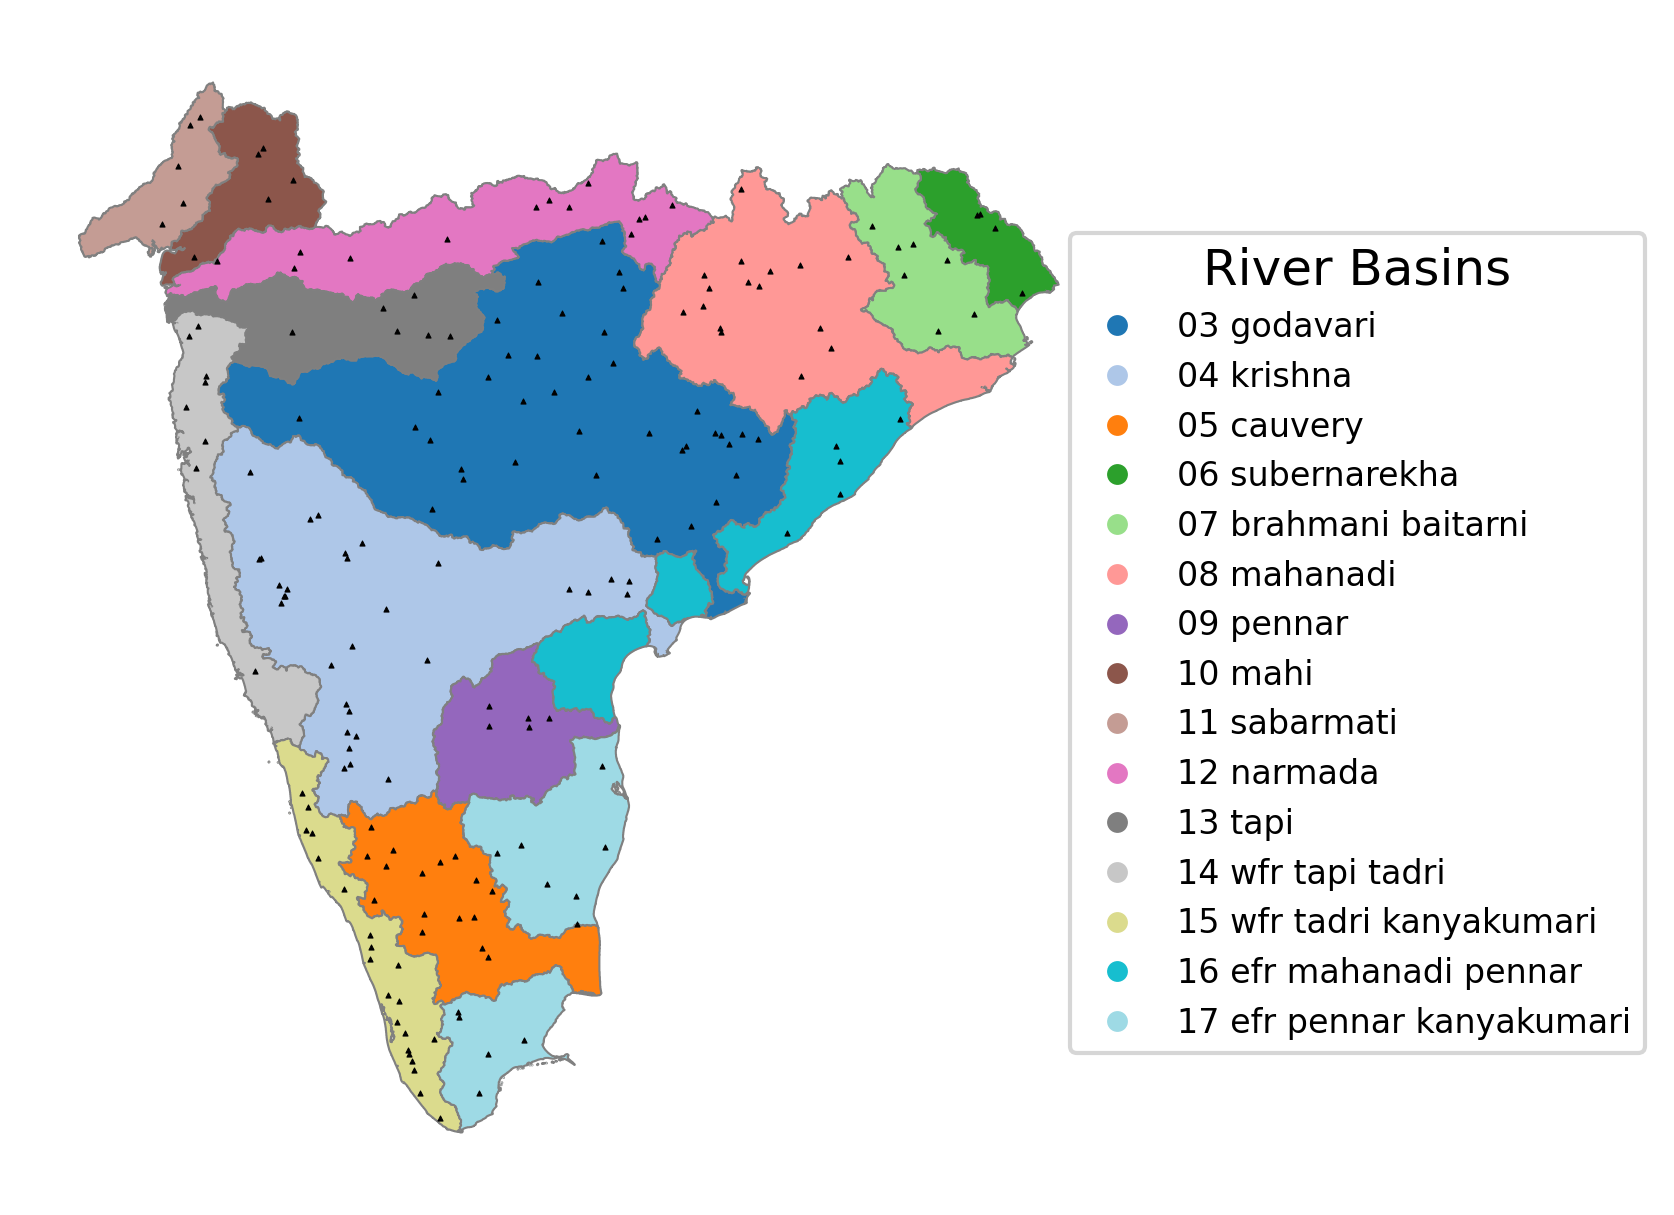

In [102]:
def plot_catchments():
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    all_watersheds_ = all_watersheds.copy()
    all_watersheds_['watershed'] = all_watersheds_['watershed'].map(lambda x: x.replace('_', ' '))
    all_watersheds_.plot(
        ax=ax,
        column='watershed',
        cmap='tab20',
        edgecolor='gray',
        linewidth=0.5,
        legend=True,
        legend_kwds={
            'loc': 'lower left',
            'bbox_to_anchor': (0.95, 0.1),
            'fontsize': 8,
            'markerscale': 0.5,
            'frameon': True,
            'facecolor': 'white',
            'ncol': 1,
            'title': 'River Basins',
            'title_fontsize': 12
        }
    )

    scatter = ax.scatter(
        camels_graph['gauge_lon'],
        camels_graph['gauge_lat'],
        c='k',
        s=1.5,
        edgecolor='black',
        linewidth=0.25,
        marker='^'
    )

    # plt.title('hysets', fontsize=8)

    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
    plt.show()
    path = f'{Paper_Data_Latency}/Figure01'
    # plt.savefig(f'{path}/Figure_01_Panel_b1.png', dpi=300, bbox_inches='tight')
    # plt.close()

plot_catchments()

# US: CAMELS-US + HYSETS

In [77]:
ecoregion_names = [
    "New England",
    "Mid-Atlantic",
    "South Atlantic-Gulf",
    "Great Lakes",
    "Ohio",
    "Tennessee",
    "Upper Mississippi",
    "Lower Mississippi",
    "Souris-Red-Rainy",
    "Missouri",
    "Arkansas-White-Red",
    "Texas-Gulf",
    "Rio Grande",
    "Upper Colorado",
    "Lower Colorado",
    "Great Basin",
    "Pacific Northwest",
    "California"
]
# Source of Names: https://water.usgs.gov/GIS/huc_name.html

In [78]:
DIRNAME = '03min_GloFAS_hysets'
SAVE_PATH = f"{PATHS['devp_datasets']}/{DIRNAME}"
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}

catmt_graph = pd.read_csv(os.path.join(SAVE_PATH, 'nested_gauges', 'graph_attributes_with_nesting.csv'))
# catmt_graph.index = catmt_graph.index.map(lambda x: str(x).zfill(8))
catmt_graph['huc_02'] = catmt_graph['huc_02'].map(lambda x: str(x).zfill(2))
# catmt_graph = catmt_graph[catmt_graph['area_percent_difference'] < 10]
# catmt_graph = catmt_graph[catmt_graph['num_nodes'] > 1]
print(f"Number of catmt's: {len(catmt_graph)}")

# catmt_graph = catmt_graph[catmt_graph['nesting'].isin(['not_nested', 'nested_downstream'])]
# catmt_graph = catmt_graph.reset_index()
# print(f"Number of catmt's: {len(catmt_graph)}")

Number of catmt's: 5149


In [79]:
#%% Region-Specific: CAMELS-US
DIRNAME = '03min_GloFAS_CAMELS-US'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(8))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(f"Number of CAMELS-US catmt's: {len(camels_graph)}")
del camels_attributes_graph

Number of CAMELS-US catmt's: 395


In [80]:
region_shp = gpd.read_file(os.path.join(PATHS['watershed-boundary-dataset'], 'huc02', 'shapefile.shp'), crs = 'epsg:4326')
all_watersheds = region_shp.copy()
all_watersheds = all_watersheds.rename(columns={'huc2': 'watershed'})
all_watersheds['huc_02'] = all_watersheds['watershed'].map(lambda x: x.split('_')[0])

In [81]:
temp = gpd.read_file(os.path.join(PATHS['CAMELS'], 'CAMELS-US', 'HCDN_nhru_final_671.shp'), crs = 'epsg:4326')
temp = temp[['hru_id', 'geometry']]
temp['hru_id'] = temp['hru_id'].map(lambda x: str(x).zfill(8))
temp = temp.set_index('hru_id')

all_catchments = camels_graph.merge(temp, left_index=True, right_index=True, how='left')
all_catchments = all_catchments[['huc_02', 'gauge_lon', 'gauge_lat', 'area_geospa_fabric', 'geometry', 'snapped_lon', 'snapped_lat']]
all_catchments = gpd.GeoDataFrame(all_catchments, crs='epsg:4326', geometry='geometry')
all_catchments = all_catchments.reset_index()
del temp

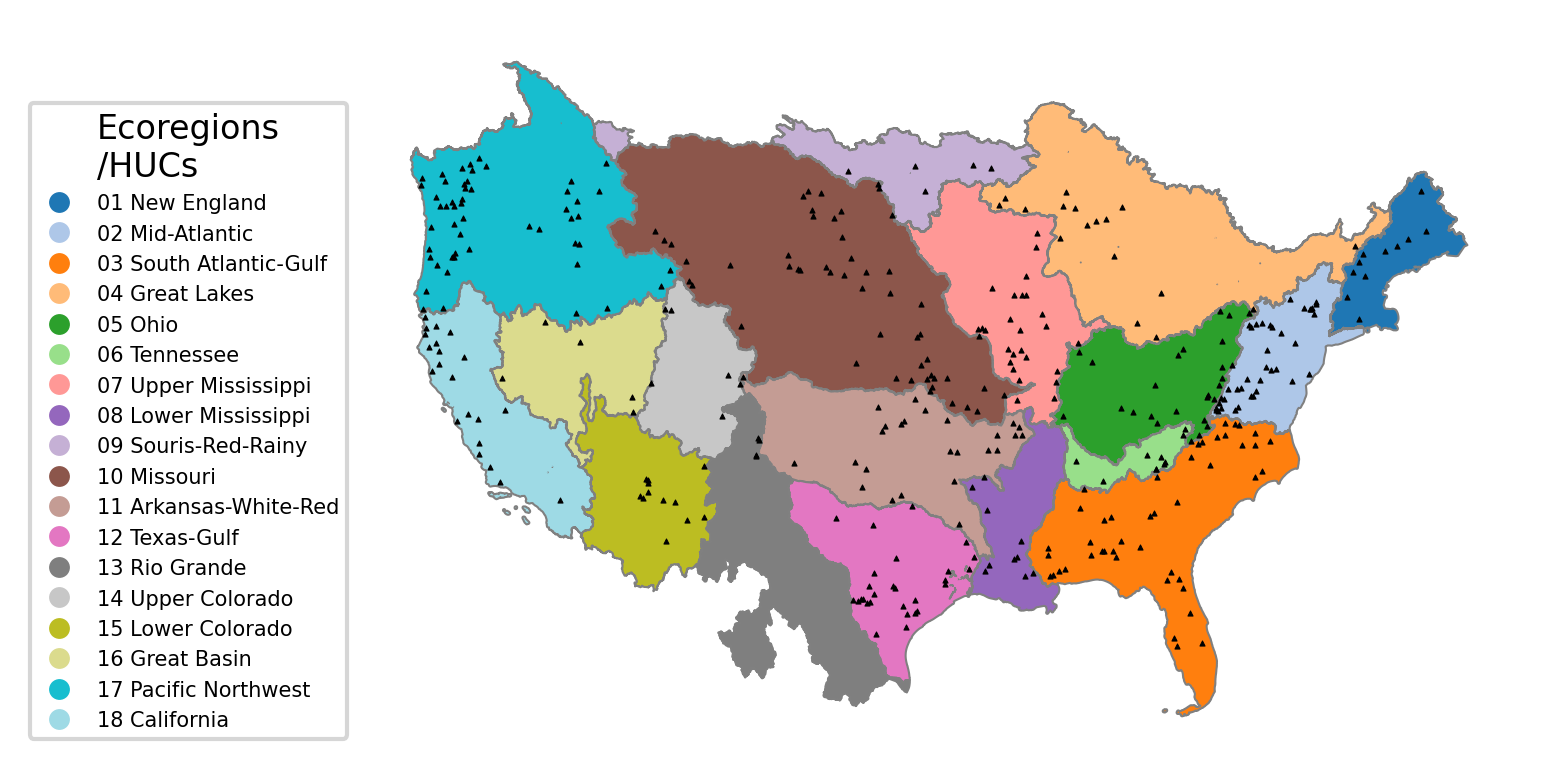

In [82]:
def plot_catchments():
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

    all_watersheds_ = all_watersheds.copy()
    # Use ecoregion_names and corresponding names next to watershed column
    all_watersheds_['watershed'] = all_watersheds_['watershed'].map(lambda x: f"{x} {ecoregion_names[int(x)-1]}")

    all_watersheds_.plot(
        ax=ax,
        column='watershed',
        cmap='tab20',
        edgecolor='gray',
        linewidth=0.5,
        legend=True,
        legend_kwds={
            'loc': 'lower right',
            'bbox_to_anchor': (0, 0.0),
            'fontsize': 5,
            'markerscale': 0.5,
            'frameon': True,
            'facecolor': 'white',
            'ncol': 1,
            'title': 'Ecoregions\n/HUCs',
            'title_fontsize': 8
        }
    )

    # scatter = ax.scatter(
    #     catmt_graph['gauge_lon'],
    #     catmt_graph['gauge_lat'],
    #     c='k',
    #     s=3,
    #     edgecolor='k',
    #     linewidth=0.25,
    #     marker='^'
    # )

    scatter = ax.scatter(
        camels_graph['gauge_lon'],
        camels_graph['gauge_lat'],
        c='k',
        s=1.5,
        edgecolor='k',
        linewidth=0.25,
        marker='^'
    )

    # plt.title('hysets', fontsize=8)

    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
    plt.show()
    path = f'{Paper_Data_Latency}/Figure01'
    # plt.savefig(f'{path}/Figure_01_Panel_b2.png', dpi=300, bbox_inches='tight')
    # plt.close()

plot_catchments()

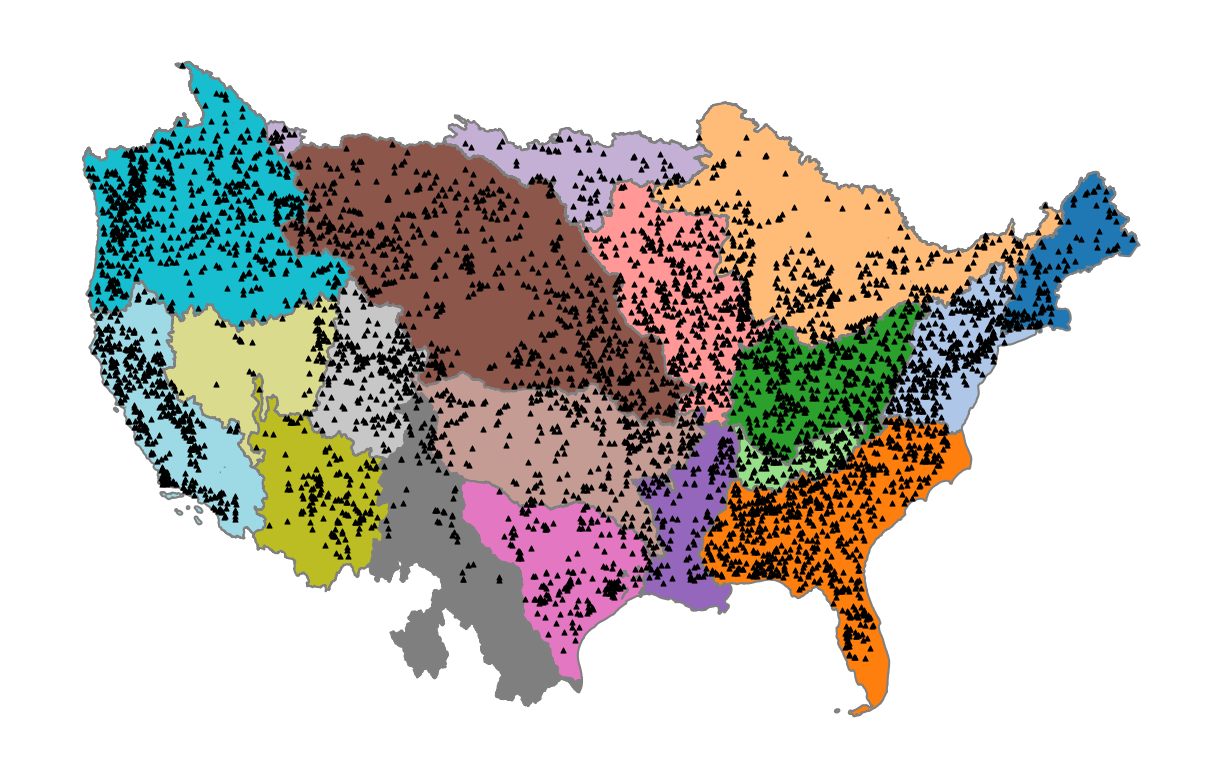

In [83]:
def plot_catchments():
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

    all_watersheds_ = all_watersheds.copy()
    # Use ecoregion_names and corresponding names next to watershed column
    all_watersheds_['watershed'] = all_watersheds_['watershed'].map(lambda x: f"{x} {ecoregion_names[int(x)-1]}")

    all_watersheds_.plot(
        ax=ax,
        column='watershed',
        cmap='tab20',
        edgecolor='gray',
        linewidth=0.5,
        legend=False,
        # legend_kwds={
        #     'loc': 'lower right',
        #     'bbox_to_anchor': (0, 0.0),
        #     'fontsize': 5,
        #     'markerscale': 0.5,
        #     'frameon': True,
        #     'facecolor': 'white',
        #     'ncol': 1,
        #     'title': 'Ecoregions\n/HUCs',
        #     'title_fontsize': 8
        # }
    )

    scatter = ax.scatter(
        catmt_graph['gauge_lon'],
        catmt_graph['gauge_lat'],
        c='k',
        s=1.5,
        edgecolor='k',
        linewidth=0.25,
        marker='^'
    )

    # scatter = ax.scatter(
    #     camels_graph['gauge_lon'],
    #     camels_graph['gauge_lat'],
    #     c='k',
    #     s=3,
    #     edgecolor='k',
    #     linewidth=0.25,
    #     marker='^'
    # )

    # plt.title('hysets', fontsize=8)

    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
    plt.show()
    path = f'{Paper_Data_Latency}/Figure01'
    # plt.savefig(f'{path}/Figure_01_Panel_b2.png', dpi=300, bbox_inches='tight')
    # plt.close()

plot_catchments()

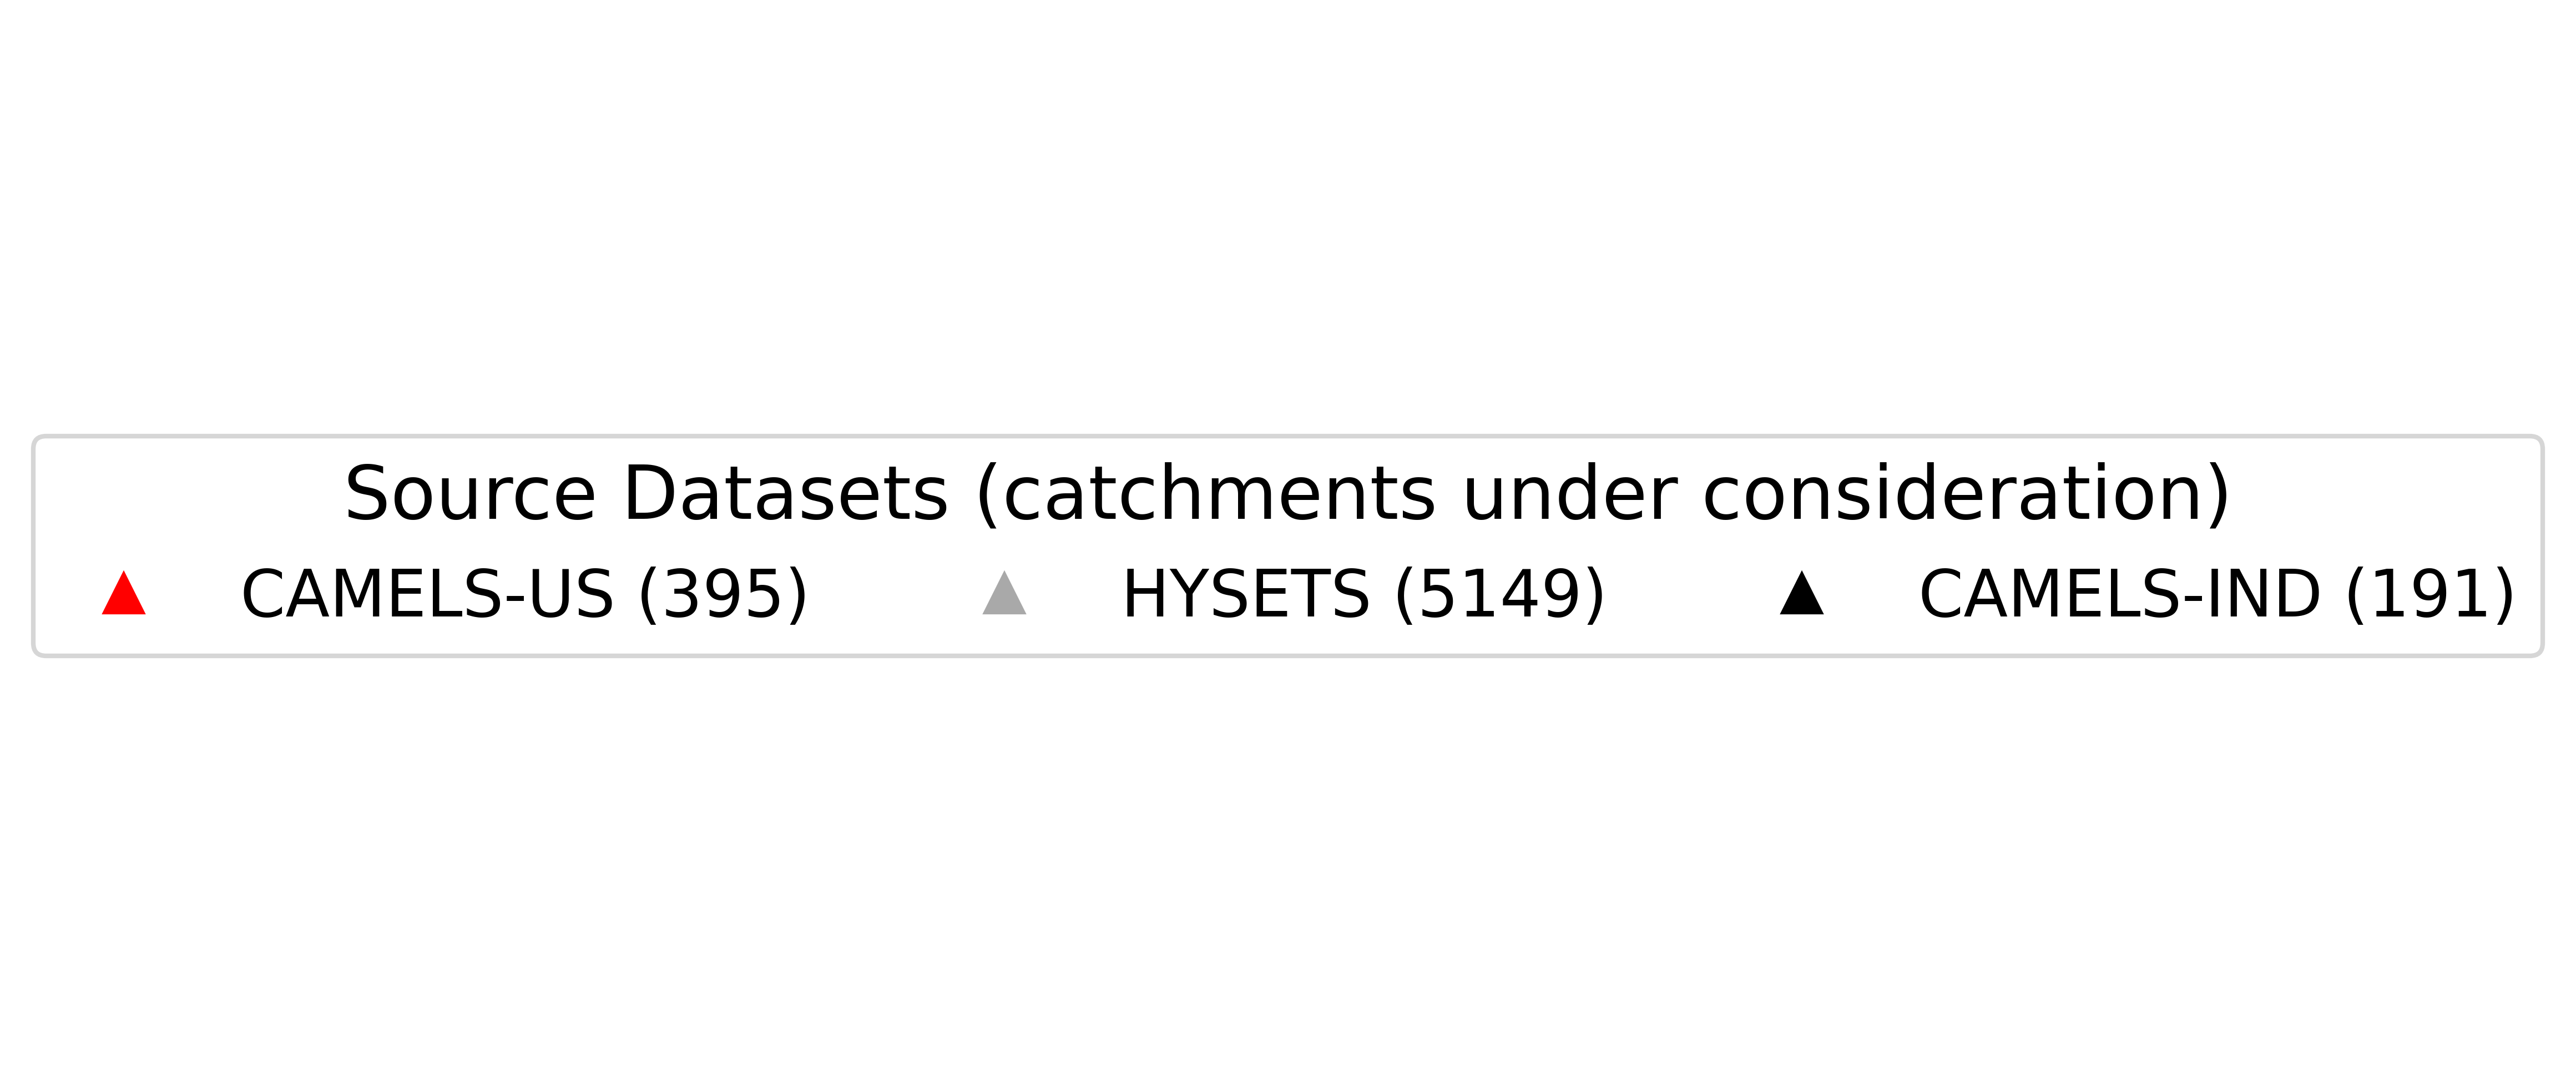

In [49]:
import matplotlib.lines as mlines

# Create legend handles for the markers
handle_camels_us = mlines.Line2D([], [], color='red', marker='^', linestyle='None', markersize=8, label="CAMELS-US (395)")
handle_hysets = mlines.Line2D([], [], color='darkgray', marker='^', linestyle='None', markersize=8, label="HYSETS (5149)")
handle_camels_ind = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=8, label="CAMELS-IND (191)")

# Create a figure with only the legend
fig, ax = plt.subplots(figsize=(6, 4), dpi= 600)
ax.legend(handles=[handle_camels_us, handle_hysets, handle_camels_ind], loc='center', frameon=True, ncol=3, fontsize=14, title="Source Datasets (catchments under consideration)", title_fontsize=16)
ax.axis('off')
plt.show()